# Self-Driving Car Engineer Nanodegree

## Topic   : Deep Learning

## Project : Traffic Sign Recognition Classifier


## Dataset Exploration

In [1]:
#Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import pickle
import csv
import collections
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
import time
from datetime import timedelta
import math
import cv2
import matplotlib.gridspec as gridspec
import os
import random


In [2]:
# Load pickled data
TrainingFile = "../traffic-signs-data/train.p"
TestingFile  = "../traffic-signs-data/test.p"
LabelsFile   = "../traffic-signs-data/signnames.csv"
with open(TrainingFile, mode='rb') as f:
    TrainingData = pickle.load(f)
with open(TestingFile, mode='rb') as f:
    TestingData = pickle.load(f)
with open(LabelsFile,mode='r') as csvfile:
    csvreader=csv.reader(csvfile)
    Labels=list(csvreader)
#Load into Arrays    
TrainFeatures, TrainLabels = TrainingData['features'], TrainingData['labels']
TestFeatures , TestLabels  = TestingData['features'] , TestingData['labels']


German Traffic Signs- Data Set Details
Number of training examples = 39209
Number of testing  examples = 12630
Number of classes           = 43
Max # of Signs              = 2250 with label Speed limit (50km/h)
Min # of Signs              = 210  with label Speed limit (20km/h)


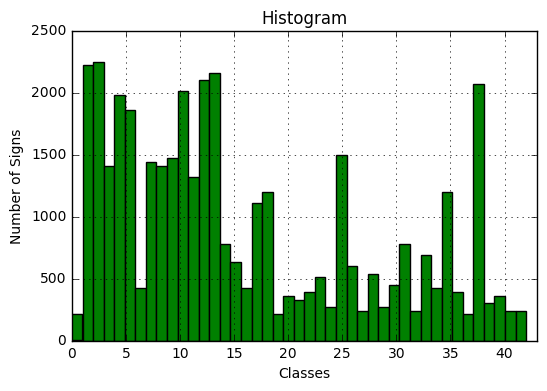

In [3]:
# Number of training,testing examples and classes
NumTrainSam = len(TrainFeatures)
NumTestSam  = len(TestFeatures)
NumClasses  = len(Labels)
#Data Exploration
#1. Count number of images in each class
ClassCount=collections.Counter(TrainLabels)
#2. Min and Max Signs
maxkey=max(ClassCount,key=ClassCount.get) # Index with max number of signs
minkey=min(ClassCount,key=ClassCount.get) # Index with min number of signs
maxnum=ClassCount[maxkey]
minnum=ClassCount[minkey]
#Convert to list. ClassList has number of images for each class
ClassList=[]
for key, values in ClassCount.items():
    ClassList.append(values)
#Print the details
print("German Traffic Signs- Data Set Details")
print("Number of training examples =", NumTrainSam)
print("Number of testing  examples =", NumTestSam)
print("Number of classes           =", NumClasses)
print("Max # of Signs              = "+str(maxnum)+" with label "+str(Labels[maxkey][1]))
print("Min # of Signs              = "+str(minnum)+"  with label "+str(Labels[minkey][1]))

#Plot the histogram
plt.figure()
plt.title('Histogram')
plt.xlabel('Classes')
plt.ylabel('Number of Signs')
plt.grid(True)
plt.axis([0,NumClasses,0,2500])
n, bins, patches = plt.hist(TrainLabels, NumClasses ,facecolor='green')



In [4]:
#Calculate data that needs to be generated and store it in ToGenNum list
ToGenNum=[]
#Print all classes
print("\n{:<55}{:<10}{:>20}".format("Traffic Sign","In Dataset","To be Generated"))
for i in range(0,NumClasses):
    String=str("{:<55}".format(Labels[i][1]))+"{:<10}".format(str(ClassList[i]))\
    +"{:>20}".format(str(maxnum-ClassList[i]))
    print(String)
    ToGenNum.append(maxnum-ClassList[i])

TotalNewData2Gen=sum(ToGenNum)
TotalDataSize=NumTrainSam+TotalNewData2Gen
print("\nTotal Data to be generated: "+str(TotalNewData2Gen))
print("Size of Total Dataset after new data is generated: "+str(TotalDataSize))


Traffic Sign                                           In Dataset     To be Generated
Speed limit (20km/h)                                   210                       2040
Speed limit (30km/h)                                   2220                        30
Speed limit (50km/h)                                   2250                         0
Speed limit (60km/h)                                   1410                       840
Speed limit (70km/h)                                   1980                       270
Speed limit (80km/h)                                   1860                       390
End of speed limit (80km/h)                            420                       1830
Speed limit (100km/h)                                  1440                       810
Speed limit (120km/h)                                  1410                       840
No passing                                             1470                       780
No passing for vechiles over 3.5 metric tons         

In [5]:
#Idea is to generate same random numbers so we can compare results after preprocessing
RandState=random.getstate() #Store randstate to get same results everytime

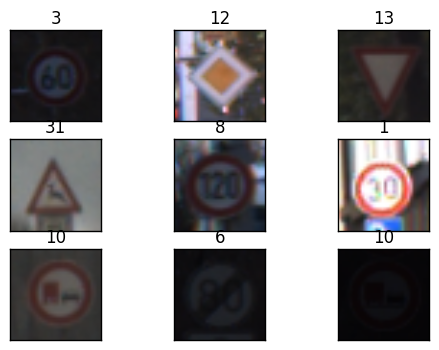

In [6]:
#Plot Random Images. 
def pltRandImages(ImgArray,ImgLabels,Rows=2):
    pltIndex=0;
    ImgIndex=0;
    gs=gridspec.GridSpec(Rows,Rows)
    random.setstate(RandState)
    ImgIndex=random.sample(range(len(ImgArray)),Rows*Rows)
    for i in range (0,Rows*Rows):
        if(pltIndex>Rows-1):
            pltIndex=0
        ax=plt.subplot(gs[int(i/Rows),pltIndex])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(ImgLabels[ImgIndex[i]])
        plt.imshow(ImgArray[ImgIndex[i]])
        pltIndex=pltIndex+1
pltRandImages(TrainFeatures,TrainLabels,3)

## Step 2: Design and Test a Model Architecture

### Question 1 

_Describe the techniques used to preprocess the data._


Data Augmentation.

From the histogram in data exploration stage we find that large number of classes are on left side of histogram showing that they are under represented. Using training data as is will make the network perform poorly on under represented traffic signs. So I generated new data, by rotating and translating images, of each class such that their number is equal to number of images in class with highest number of images.

Pre Processing 

Images were first adjusted for global constrast using histogram equalization. Then local contrast equaliztion is done using contrast limited adaptive histogram equalization.

### 1. Augmenting Training Data


In [7]:
GenShape=(TotalNewData2Gen,32,32,3) #Shape of array to hold generated data
TrainFeaturesGen=np.zeros(GenShape,TrainFeatures.dtype)     #Array to hold generated images
TrainLabelsGen=np.zeros(TotalNewData2Gen,TrainLabels.dtype) #Array to hold generated labels

# Generate to be generated number of random index from each class
RandImgIndex=[]
Count=0
for i in range(0,NumClasses):
    RandImgIndex.append(np.random.randint(Count,Count+ClassList[i],ToGenNum[i]))
    Count=Count+ClassList[i]

#Generating Augmented Data by Rotating, Scaling and Changing Positions
#Values are from [1]
IndexCount=0
for i in range(0,NumClasses):
    print("Generating "+str(ToGenNum[i])+" "+str(Labels[i][1])+" features and labels")
    for j in range(0,ToGenNum[i]):
        Image=TrainFeatures[RandImgIndex[i][j]]
        #Rotation
        MaxRotAngle=15
        rows,cols,chnls=Image.shape
        RotMatrix=cv2.getRotationMatrix2D((rows/2,cols/2),random.uniform(-MaxRotAngle,MaxRotAngle),1)
        Image=cv2.warpAffine(Image,RotMatrix,(rows,cols))
        #Translation
        TransMatrix=np.float32([[1,0,random.uniform(-2,2)],[0,1,random.uniform(-2,2)]])
        Image=cv2.warpAffine(Image,TransMatrix,(rows,cols))
        #Scale
        #Image=cv2.resize(Image,None,fx=random.uniform(0.9,1.1),fy=random.uniform(0.9,1.1),interpolation=cv2.INTER_CUBIC)
        TrainFeaturesGen[IndexCount]=Image
        TrainLabelsGen[IndexCount]=i
        IndexCount=IndexCount+1
#Booleans to prevent doing accumulation or pre processing being done multiple times
DataAccDone=False    #Data Accumulation Done
PreProcessDone=False #Pre Processing Done
ValSplitDone=False

Generating 2040 Speed limit (20km/h) features and labels
Generating 30 Speed limit (30km/h) features and labels
Generating 0 Speed limit (50km/h) features and labels
Generating 840 Speed limit (60km/h) features and labels
Generating 270 Speed limit (70km/h) features and labels
Generating 390 Speed limit (80km/h) features and labels
Generating 1830 End of speed limit (80km/h) features and labels
Generating 810 Speed limit (100km/h) features and labels
Generating 840 Speed limit (120km/h) features and labels
Generating 780 No passing features and labels
Generating 240 No passing for vechiles over 3.5 metric tons features and labels
Generating 930 Right-of-way at the next intersection features and labels
Generating 150 Priority road features and labels
Generating 90 Yield features and labels
Generating 1470 Stop features and labels
Generating 1620 No vechiles features and labels
Generating 1830 Vechiles over 3.5 metric tons prohibited features and labels
Generating 1140 No entry features 

Data Accumulation Started
Data Accumulation Done


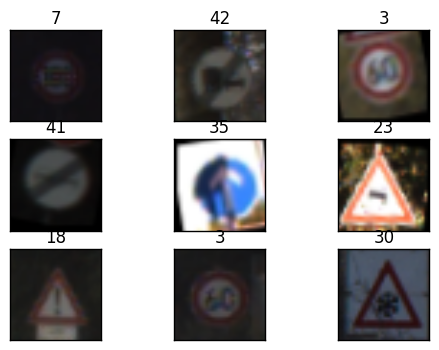

In [8]:
#Accumulating Generated Data with Original Data
if(DataAccDone==False):
    print("Data Accumulation Started")
    TrainFeatures=np.append(TrainFeatures,TrainFeaturesGen,axis=0)
    TrainLabels=np.append(TrainLabels,TrainLabelsGen)
    DataAccDone=True
    print("Data Accumulation Done")
assert(TrainFeatures.shape[0]==TotalDataSize)
pltRandImages(TrainFeatures,TrainLabels,3)

### 2. Pre Processing Data

In [9]:
#Pre Processing all the Images now
def preProcess(Img):
    Image=Img
    #Global Histogram Equilization
    Image[:,:,0]=cv2.equalizeHist(Image[:,:,0])
    Image[:,:,1]=cv2.equalizeHist(Image[:,:,1])
    Image[:,:,2]=cv2.equalizeHist(Image[:,:,2])
    #Local Histogram Equilization
    clahe=cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    Image[:,:,0]=clahe.apply(Image[:,:,0])
    Image[:,:,1]=clahe.apply(Image[:,:,1])
    Image[:,:,2]=clahe.apply(Image[:,:,2])
    return Image
#Pre Processing Training Image
if(PreProcessDone==False):
    print("Pre Processing Data Started")
    TrainFeaturesPP=np.zeros(TrainFeatures.shape,TrainFeatures.dtype)
    TestFeaturesPP=np.zeros(TestFeatures.shape,TrainFeatures.dtype)
    for i in range(0,len(TrainFeatures)):
        TrainFeaturesPP[i]=preProcess(TrainFeatures[i])
    for i in range(0,len(TestFeatures)):
        TestFeaturesPP[i]=preProcess(TestFeatures[i])
    PreProcessDone=True
    print("Pre Processing Done")


Pre Processing Data Started
Pre Processing Done


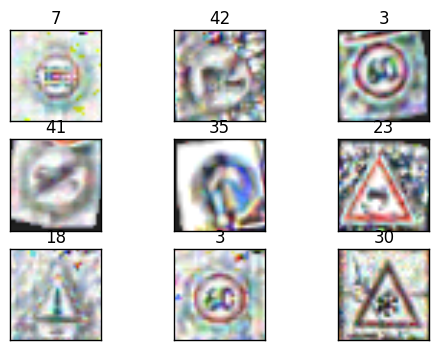

In [10]:
#Plotting Training Images after pre-processing
pltRandImages(TrainFeaturesPP,TrainLabels,3)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** 
25% of training dataset is set aside for validation. Test Dataset is left as is.

### Splitting into Validation and Training Sets

In [13]:
#Splitting into Train and Validation Sets
ValSize=0.25 #25%
if(ValSplitDone==False):
    TrainFeaturesPP, ValFeaturesPP, TrainLabels, ValLabels = train_test_split(
     TrainFeaturesPP,TrainLabels, test_size=ValSize, random_state=2)
    ValSplitDone=True
assert((ValFeaturesPP.shape[0]+TrainFeaturesPP.shape[0])==TotalDataSize)

In [14]:
#Convert Labels into One hot encoded Labels
def LabelEncoder(Labels,NumLabels):
    """Takes in Normal labels and returns onehot encoded labels"""
    Encoder=OneHotEncoder()
    Encoder.fit(np.arange(NumLabels).reshape(-1,1))
    EncodedLabels=Encoder.transform(Labels.reshape(-1,1)).toarray()
    return EncodedLabels
TrainLabelsOHE=LabelEncoder(TrainLabels,NumClasses)
ValLabelsOHE  =LabelEncoder(ValLabels,NumClasses)
TestLabelsOHE =LabelEncoder(TestLabels,NumClasses)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._

**Answer:**

### Network 

In [15]:
#Helper Functions for CNN Layers
def CreateConvLayer(input,NumChnls,FilSize,NumFils,Stride=1,pooling=True):
    #Create shape of filter
    FilterShape=[FilSize,FilSize,NumChnls,NumFils]
    #Create variables for weights and Biases
    #Weights=tf.Variable(tf.truncated_normal(FilterShape,stddev=0.05))
    Weights=tf.get_variable("Weights"+str(random.randint(0,len(TrainFeaturesPP))),
                            shape=FilterShape,initializer=tf.contrib.layers.xavier_initializer())
    Biases=tf.Variable(tf.constant(0.05,shape=[NumFils]))
    #Convolution Output
    ConvOpt=tf.nn.conv2d(input=input,filter=Weights,strides=[1,Stride,Stride,1],padding='SAME')
    #Add ConvOpt to Biases
    LayerOpt=tf.nn.bias_add(ConvOpt,Biases)
    #MaxPooling
    if(pooling==True):
        LayerOpt=tf.nn.max_pool(LayerOpt,[1,2,2,1],[1,2,2,1],'SAME')
    #Perform Relu
    LayerOpt=tf.nn.relu(LayerOpt)
    return LayerOpt,Weights
#Flatten Layer to input to Fully Connected Layer
def FlattenLayer(layer):
    LayerShape=layer.get_shape()
    NumFeatures =LayerShape[1:4].num_elements()
    LayerFlat=tf.reshape(layer,[-1,NumFeatures])
    return LayerFlat,NumFeatures
#Fully Connected Layer
def CreateFCLayer(input,NumInputs,NumOutputs,relu=True):
    #Weight Shape
    WShape=[NumInputs,NumOutputs]
    #Create Variables for Weights and Biases
    #Weights=tf.Variable(tf.truncated_normal(WShape,stddev=0.05))
    Weights=tf.get_variable("Weights"+str(random.randint(0,len(TrainFeaturesPP))),
                            shape=WShape,initializer=tf.contrib.layers.xavier_initializer())
    Biases=tf.Variable(tf.constant(0.05,shape=[NumOutputs]))
    #Calculate FC
    FCLayer=tf.matmul(input,Weights)+Biases
    if(relu==True):
        FCLayer=tf.nn.relu(FCLayer)
    return FCLayer, Weights

In [34]:
def MyCNN(x,DropVal):
    FilterSize=[5,5]
    NumFilters=[32,64]
    FCSize=[2048,1024,512,128]
    #Layer1
    L1Conv, L1ConvWeight=CreateConvLayer(x,3,FilterSize[0],NumFilters[0])
    L1Conv=tf.nn.lrn(L1Conv,depth_radius=2,bias=1.0,alpha=2e-05,beta=0.75)
    #Layer2
    L2Conv, L2ConvWeight =CreateConvLayer(L1Conv,NumFilters[0],FilterSize[1],NumFilters[1])
    L2Conv=tf.nn.lrn(L2Conv,depth_radius=2,bias=1.0,alpha=2e-05,beta=0.75)  
    #Flatten
    FCFlat, NumFeatures=FlattenLayer(L2Conv)
    #FC1
    FC1,FC1W=CreateFCLayer(FCFlat,NumFeatures,FCSize[0])
    FC1=tf.nn.dropout(FC1,DropVal)
    FC2,FC2W=CreateFCLayer(FC1,FCSize[0],FCSize[1])
    FC2=tf.nn.dropout(FC2,DropVal)
    FC3,FC3W=CreateFCLayer(FC2,FCSize[1],FCSize[2])
    FC3=tf.nn.dropout(FC3,DropVal)
    FC4,FC4W=CreateFCLayer(FC3,FCSize[2],FCSize[3])
    #FC4=tf.nn.dropout(FC4,DropVal)
    FC5,FC5W=CreateFCLayer(FC4,FCSize[3],NumClasses,relu=False)
    print(DropVal)
    return L1ConvWeight,L2ConvWeight,FC1W,FC2W,FC3W,FC4W,FC5W,FC5
    

In [35]:
#PlaceHolder for Image
ImgPH=tf.placeholder(tf.float32,[None,32,32,3])
#Placeholders for Labels
LabelPH_OHE  =tf.placeholder(tf.float32,[None,NumClasses])
LabelPH_Plain=tf.placeholder(tf.float32,[None])
#Placeholder for avoiding dropout during inference
DropVal1=tf.placeholder(tf.float32)

In [36]:
#Running through network
L1ConvWeight,L2ConvWeight,FC1W,FC2W,FC3W,FC4W,FC5W,NetworkOpt=MyCNN(ImgPH,DropVal=DropVal1)
#Applying Softmax to predict
ClassPredOHE = tf.nn.softmax(NetworkOpt)
#Selecting the highest probability to get normal lable
ClassPred    = tf.argmax(ClassPredOHE, dimension=1)
#Casting
ClassPred    = tf.cast(ClassPred,tf.float32)

Tensor("Placeholder_7:0", dtype=float32)


In [37]:
#Optimization
L2RegularVal=(tf.nn.l2_loss(L1ConvWeight))+(tf.nn.l2_loss(L2ConvWeight))+(tf.nn.l2_loss(FC1W))+(tf.nn.l2_loss(FC2W))+(tf.nn.l2_loss(FC3W))+(tf.nn.l2_loss(FC4W))+(tf.nn.l2_loss(FC5W))
CrossEntorpy = tf.nn.softmax_cross_entropy_with_logits(logits=NetworkOpt,labels=LabelPH_OHE)
Cost = tf.reduce_mean(CrossEntorpy)+(L2RegularVal*1e-5)
Optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(Cost)

In [38]:
#Accuracy
CorrectPred = tf.equal(ClassPred,LabelPH_Plain)
Accuracy = tf.reduce_mean(tf.cast(CorrectPred, tf.float32))

In [39]:
#TensorFlow Save 
Saver = tf.train.Saver()
SaveDir='Checkpoints/'
#Create Savedir if it doesnt exist
if not os.path.exists(SaveDir):
    os.makedirs(SaveDir)
SavePath = SaveDir + 'BestVal'

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
Batch Size is 1200, Epochs=29600

### Training and Optimization

In [40]:
#Initialization
session=tf.Session()
session.run(tf.global_variables_initializer())

In [41]:
#Session Saver
saver=tf.train.Saver()
#saver.restore(sess=session,save_path=SaveDir)

In [42]:
TotalRuns=0
BestValAcc=0.0
def TrainCNN(NumRuns,BatchSize):
    print("Training Started")
    global TotalRuns
    global BestValAcc
    #TrainAccList=[]
    #ValAccList=[]
    #TrainCostList=[]
    #Keep track of time to report at last
    StartTime=time.time()
    for i in range(TotalRuns,TotalRuns+NumRuns):
        TotalRuns=TotalRuns+1
        #Choose BatchSize number of indices randomly without replacement
        TrainIndex=np.random.choice(len(TrainFeaturesPP),BatchSize,replace=False)
        #Dictionary for Optimizer
        TrainDict= {
            ImgPH:TrainFeaturesPP[TrainIndex,:],
            DropVal1:0.5,
            LabelPH_OHE:TrainLabelsOHE[TrainIndex,:]
        }
        #Running Optimizer
        session.run(Optimizer,TrainDict)
        #Dictionary for Calculating Training accuracy of this batch
        TrainAccDict={
            ImgPH:TrainFeaturesPP[TrainIndex,:],
            DropVal1:1,
            LabelPH_OHE:TrainLabelsOHE[TrainIndex,:],
            LabelPH_Plain:TrainLabels[TrainIndex]
        }
        #For Every 500 Iterations give accuracy
        if ((TotalRuns%500==0) or (i==(NumRuns-1))):
            #Calculate Training Accuracy
            TrainAcc=session.run(Accuracy,TrainAccDict)
            ValAcc=CalAcc("Val",BatchSize)
            TestAcc=CalAcc("Test",BatchSize)
            #TrainCost=session.run(Cost,TrainAccDict)
            #Values for plotting later
            #TrainAccList.append(TrainAcc)
            #ValAccList.append(ValAcc)
            #TrainCostList.append(TrainCost)
            #Saving good stuff
            if (ValAcc>=BestValAcc):
                BestValAcc=ValAcc
                saver.save(sess=session,save_path=SaveDir)
                ImpStr="*"
            else:
                ImpStr=" "
            msg = "Iter: {0:>6}, Train-Batch Accuracy: {1:>6.1%}, Validation Acc: {2:>6.1%} {3} Test Acc:{4:>4.1%}"
            print(msg.format(i + 1,TrainAcc,ValAcc,ImpStr,TestAcc))
    #Ending and reporting results
    EndTime=time.time()
    TimeDelta=EndTime-StartTime
    print("Total Time ="+str(timedelta(seconds=int(round(TimeDelta)))))
    #return TrainAccList,ValAccList,TrainCostList

In [43]:
def CalAcc(Type="Val",BatchSize=100):
    AccuracyVal=0
    if(Type=="Val"):
        ValIndex=np.random.choice(len(ValFeaturesPP),BatchSize,replace=False)
        ValAccDict={
            ImgPH:ValFeaturesPP[ValIndex,:],
            DropVal1:1,            
            LabelPH_OHE:ValLabelsOHE[ValIndex,:],
            LabelPH_Plain:ValLabels[ValIndex]            
        }
        AccuracyVal=session.run(Accuracy,ValAccDict)
    if(Type=="Test"):
        TestIndex=np.random.choice(len(TestFeaturesPP),BatchSize,replace=False)
        TestAccDict={
            ImgPH:TestFeaturesPP[TestIndex,:],
            DropVal1:1,
            LabelPH_OHE:TestLabelsOHE[TestIndex,:],
            LabelPH_Plain:TestLabels[TestIndex]            
        }
        AccuracyVal=session.run(Accuracy,TestAccDict)
    return AccuracyVal
    

In [47]:
#TrainAccList,ValAccList,TrainCostList=TrainCNN(2500,300)
TrainCNN(2500,300)

Training Started
Iter:   8000, Train-Batch Accuracy: 100.0%, Validation Acc:  99.3% * Test Acc:96.3%
Iter:   8500, Train-Batch Accuracy: 100.0%, Validation Acc:  99.0%   Test Acc:97.7%
Iter:   9000, Train-Batch Accuracy: 100.0%, Validation Acc:  99.7% * Test Acc:98.0%
Iter:   9500, Train-Batch Accuracy: 100.0%, Validation Acc:  99.0%   Test Acc:97.3%
Iter:  10000, Train-Batch Accuracy: 100.0%, Validation Acc:  99.3%   Test Acc:97.7%
Total Time =0:01:13


In [48]:
CalAcc("Test",2000)

0.96850002

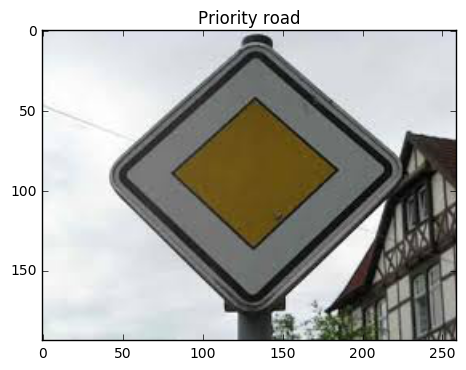

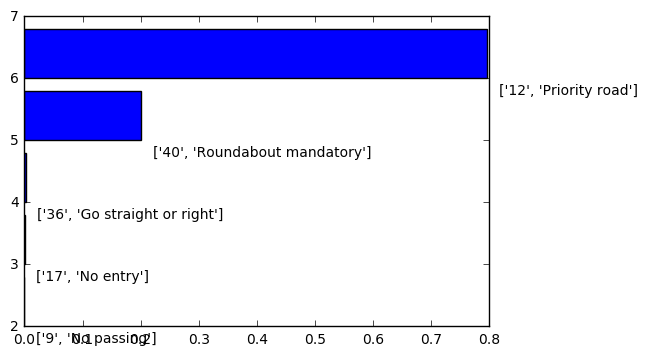

In [60]:
def ClassifyImg(ImgName):
    dim=(32,32)
    Image=cv2.imread(ImgName)
    Image1=Image
    Image=cv2.resize(Image,dim,cv2.INTER_CUBIC)
    Image=preProcess(Image)
    TestDict={ImgPH:[Image,Image],DropVal1:1,LabelPH_OHE:TestLabelsOHE}
    Val=session.run(ClassPred,TestDict)
    Val=Val.astype(int)
    plt.figure(0)
    plt.imshow(cv2.cvtColor(Image1,cv2.COLOR_BGR2RGB))
    plt.title(Labels[Val[0]][1])
    top5=tf.nn.top_k(ClassPredOHE,5)
    predictions=session.run(ClassPredOHE,TestDict)
    top5_pred=session.run([ClassPredOHE,top5],TestDict)
    plt.figure(1)
    plt.barh(6-np.arange(5),top5_pred[1][0][0])
    for i in range(5):
        plt.text(top5_pred[1][0][0][i]+.02,6-i-.25,Labels[top5_pred[1][1][0][i]])

#ClassifyImg("Round1.jpg")
#ClassifyImg("stop2.png")
ClassifyImg("test1.jpg")
#ClassifyImg("50mph.jpg")
#ClassifyImg("stop_test.jpg")
#ClassifyImg("rdwork.jpg")
#ClassifyImg("40mph.jpg")
#ClassifyImg("60mph.jpg")


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.